# Group 16
anderdav@students.zhaw.ch \
goodnic1@students.zhaw.ch \
janick.rueegger@students.fhnw.ch \
neyerjoh@students.zhaw.ch

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

Load train and test partition of the MNIST dataset.

Prepare the training by splitting the training partition into a training and validation.

In [2]:
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
# Partition into train and validate

### YOUR CODE START ###

training_set, validation_set = torch.utils.data.random_split(training_data, [50000, 10000])

### YOUR CODE END ###

### MLP

Implement an MLP model that can be configured with a an arbitrary number of layers and units per layer.

To that end, implement a suitable sub-class of `torch.nn.Module` with a constructor that accepts the following arguments:
* `units`: list of integers that specify the number of units in the different layers. The first element corresponds to the number of units in the input layer (layer '0'), the last element is the number of output units, i.e. the number of classes the classifier is designed for (10 for an MNIST classifier). Hence, MLP will have $n$ hidden layers if `units` has $n+1$ elements. 
* `activation_class`: Class name of the activation function layer to be used (such as `torch.nn.ReLU`). Instances can be created by `activation_class()` and added to the succession of layers defined by the model. 

Alternatively, you can implement a utility method that creates a `torch.nn.Sequential` model accordingly. 


In [4]:
### YOUR CODE START ###

class MLP(torch.nn.Module):
    
    def __init__(self, units, activation_class = torch.nn.ReLU):
        super().__init__()
        layers = []
        for cur, nxt in zip(units, units[1:]):
            layers.append(torch.nn.Linear(cur, nxt))
            layers.append(activation_class())
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            *layers
        )
        
    def forward(self, x):
        return self.layers(x)
        

### YOUR CODE END ###

In [5]:
model = MLP([28*28,300, 100, 10])

from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
              ReLU-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


### Training Loop

For training, implement a method with the arguments:
* `model`: Model to be trained
* `lr`: Learning rate
* `nepochs`: Number of epochs
* `batchsize`: Batch size
* `training_data`: Training set (subclassed of `Dataset`)
* `validation_data`: Validation set (subclassed of `Dataset`)

Remember the training and validation cost and accuracy, respectively for monitoring the progress of the training. <br>
Note that for the training cost and accuracy you can use the per batch quantities averaged over an epoch. 

Furthermore, you can use the SGD optimizer of pytorch (`torch.optim.SGD`) - but without momentum.

In [6]:
def train_eval(model, lr, nepochs, nbatch, training_set, validation_set):
    # finally return the sequence of per epoch values
    cost_hist = []
    cost_hist_valid = []
    acc_hist = []
    acc_hist_valid = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    ### YOUR CODE START ###
    
    # epoch: current epoch
    # cost, cost_valid, acc, acc_valid: cost and acurracy (for training, validation set) per epoch     
    
    training_loader = DataLoader(training_set, batch_size=nbatch)
    validation_loader = DataLoader(validation_set, batch_size=nbatch)
    
    for epoch in range(nepochs):

        training_cost = 0
        correct = 0
        for inputs, targets in training_loader:
            optimizer.zero_grad()
            predictions = model(inputs)
            cost = cost_ce(predictions, targets)
            cost.backward()
            optimizer.step()
            training_cost += cost.item()
            correct += (torch.argmax(predictions, dim=1) == targets).sum()
        
        cost = training_cost / len(training_set)
        acc = correct / len(training_set)

        validation_cost = 0
        correct = 0
        for inputs, targets in validation_loader:
            predictions = model(inputs)
            val_cost = cost_ce(predictions, targets)
            validation_cost += val_cost.item()
            correct += (torch.argmax(predictions, dim=1) == targets).sum()

        cost_valid = validation_cost / len(validation_set)
        acc_valid = correct / len(validation_set)
        
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_valid, acc_valid))

        ### YOUR CODE END ###
        
        cost_hist.append(cost)
        cost_hist_valid.append(cost_valid)
        acc_hist.append(acc)
        acc_hist_valid.append(acc_valid)
    return cost_hist, cost_hist_valid, acc_hist, acc_hist_valid

### Exploration

Now use this functionality to explore different layer configurations: 
* Number of layers
* Number of units per layer
* Suitable learning rate
* Suitable number of epochs.

Use a batchsize of 64.

Make sure that you choose a sufficinetly large number of epochs so that the learning has more or less stabilizes (converged). 

In [7]:
def plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid):
    plt.figure(1)
    plt.plot(torch.arange(nepochs), cost_hist, '-', label='training')
    plt.plot(torch.arange(nepochs), cost_hist_valid, 'r-', label='validation')
    plt.xlabel('Epoch')
    plt.legend()
    plt.xlim(0,nepochs)
    plt.ylim(0,0.1)
    plt.title('Cross-Entropy Cost')
    plt.figure(2)
    plt.plot(torch.arange(nepochs), acc_hist,"-", label='training')
    plt.plot(torch.arange(nepochs), acc_hist_valid,"r-", label='validation')
    plt.xlabel('Epoch')
    plt.legend()
    plt.xlim(0,nepochs)
    plt.ylim(0.6,1)
    plt.title('Accuracy')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
              ReLU-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
              ReLU-5                   [-1, 10]               0
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Epoch 0: 0.011976, 0.741400, 0.010510, 0.769700
Epoch 1: 0.007583, 0.852040, 0.005909, 0.891900
Epoch 2: 0.005399, 0.903180, 0.005825, 0.896100
Epoch 3: 0.004973, 0.911100, 0.005427, 0.899500
Epoch 4: 0.004673, 0.916760, 0.005787, 0.89650

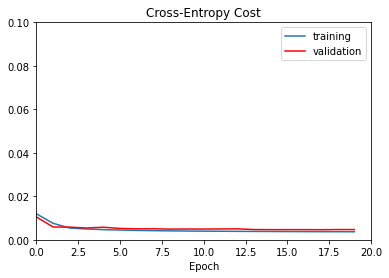

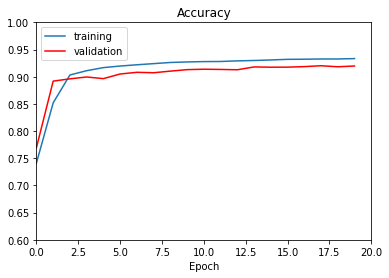

In [23]:
best_relu = MLP([28*28, 10, 10])
learning_rate = 0.5
nepochs = 20
nbatch = 64

summary(best_relu, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(best_relu, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
              ReLU-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
              ReLU-5                   [-1, 10]               0
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Epoch 0: 0.008188, 0.843480, 0.005855, 0.889200
Epoch 1: 0.005477, 0.898800, 0.005586, 0.895100
Epoch 2: 0.005143, 0.907560, 0.007275, 0.870700
Epoch 3: 0.004897, 0.911560, 0.006574, 0.883400
Epoch 4: 0.004725, 0.915340, 0.006673, 0.88070

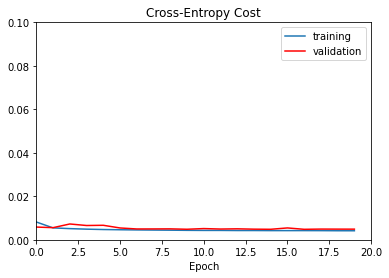

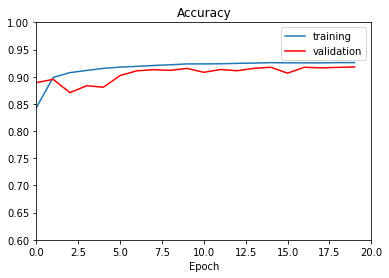

In [9]:
model = MLP([28*28, 10, 10])
learning_rate = 0.75
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
              ReLU-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
              ReLU-5                   [-1, 10]               0
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Epoch 0: 0.023935, 0.465780, 0.020402, 0.545100
Epoch 1: 0.020548, 0.549360, 0.020550, 0.543900
Epoch 2: 0.021979, 0.503660, 0.021896, 0.516700
Epoch 3: 0.022949, 0.496500, 0.027254, 0.384000
Epoch 4: 0.025019, 0.424800, 0.024563, 0.42390

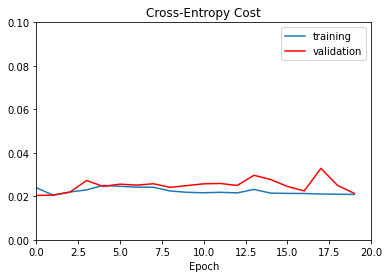

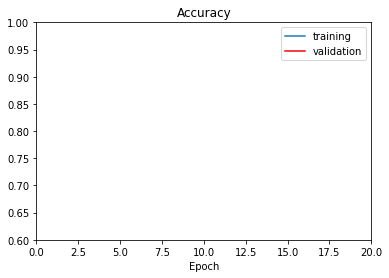

In [10]:
model = MLP([28*28, 10, 10])
learning_rate = 0.9
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
              ReLU-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
Epoch 0: 0.017404, 0.602420, 0.014015, 0.654600
Epoch 1: 0.012954, 0.672180, 0.012612, 0.678000
Epoch 2: 0

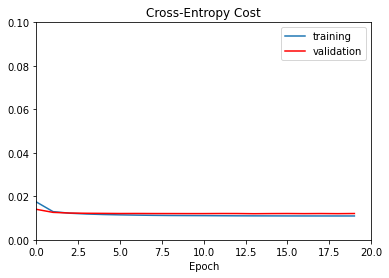

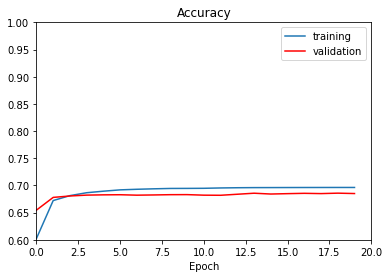

In [11]:
model = MLP([28*28, 300, 100, 10])
learning_rate = 0.2
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
              ReLU-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
Epoch 0: 0.010990, 0.753780, 0.006074, 0.859900
Epoch 1: 0.005070, 0.879780, 0.001891, 0.964400
Epoch 2: 0

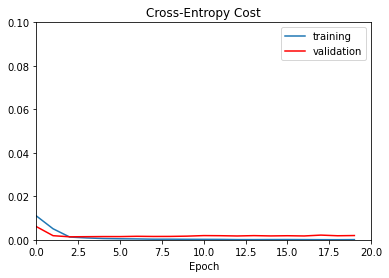

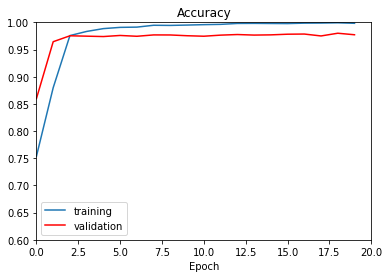

In [12]:
model = MLP([28*28, 300, 100, 10])
learning_rate = 0.5
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
              ReLU-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
Epoch 0: 0.007334, 0.846600, 0.002065, 0.961400
Epoch 1: 0.001865, 0.964020, 0.001569, 0.970900
Epoch 2: 0

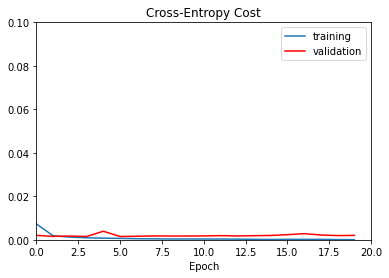

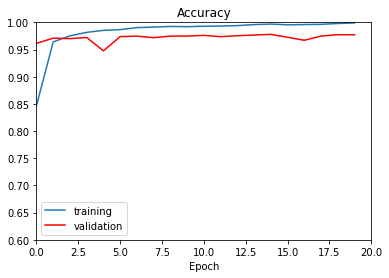

In [13]:
model = MLP([28*28, 300, 100, 10])
learning_rate = 0.8
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 5000]       3,925,000
              ReLU-3                 [-1, 5000]               0
            Linear-4                  [-1, 300]       1,500,300
              ReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
              ReLU-9                   [-1, 10]               0
Total params: 5,456,410
Trainable params: 5,456,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 20.81
Estimated Total Size (MB): 20.91
-------------------------------------

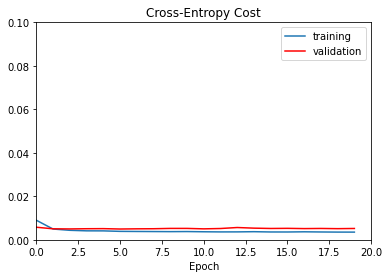

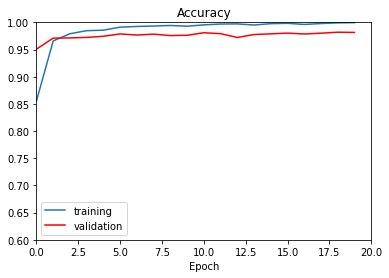

In [14]:
model = MLP([28*28, 5000, 300, 100, 10])
learning_rate = 0.5
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
           Sigmoid-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
           Sigmoid-5                   [-1, 10]               0
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Epoch 0: 0.030819, 0.646360, 0.028101, 0.792200
Epoch 1: 0.027094, 0.815400, 0.026490, 0.833700
Epoch 2: 0.026016, 0.832380, 0.025808, 0.840600
Epoch 3: 0.025534, 0.834240, 0.025460, 0.844600
Epoch 4: 0.025265, 0.835560, 0.025254, 0.84580

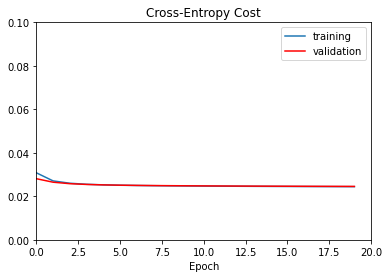

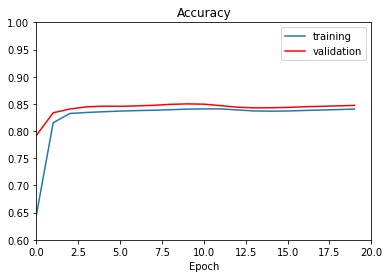

In [15]:
model = MLP([28*28, 10, 10], torch.nn.Sigmoid)
learning_rate = 0.5
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
           Sigmoid-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
           Sigmoid-5                   [-1, 10]               0
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Epoch 0: 0.029813, 0.697020, 0.027235, 0.822300
Epoch 1: 0.026372, 0.838440, 0.025940, 0.863500
Epoch 2: 0.025600, 0.864080, 0.025489, 0.879500
Epoch 3: 0.025271, 0.877600, 0.025249, 0.889200
Epoch 4: 0.025068, 0.885860, 0.025074, 0.89260

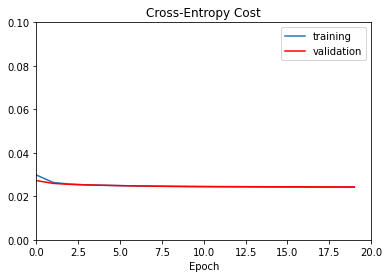

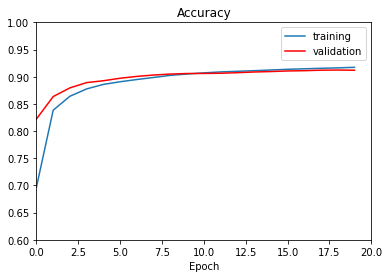

In [16]:
model = MLP([28*28, 10, 10], torch.nn.Sigmoid)
learning_rate = 0.75
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
           Sigmoid-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
           Sigmoid-5                   [-1, 10]               0
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Epoch 0: 0.029320, 0.711160, 0.026718, 0.822800
Epoch 1: 0.025995, 0.831300, 0.025671, 0.832800
Epoch 2: 0.025368, 0.835380, 0.025295, 0.839600
Epoch 3: 0.025093, 0.839980, 0.025089, 0.845700
Epoch 4: 0.024928, 0.846400, 0.024954, 0.85600

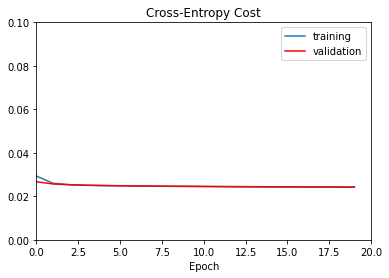

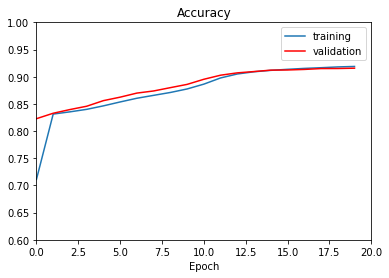

In [17]:
model = MLP([28*28, 10, 10], torch.nn.Sigmoid)
learning_rate = 0.9
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
           Sigmoid-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
           Sigmoid-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
           Sigmoid-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
Epoch 0: 0.035938, 0.116380, 0.035894, 0.117400
Epoch 1: 0.034253, 0.363660, 0.031306, 0.556900
Epoch 2: 0

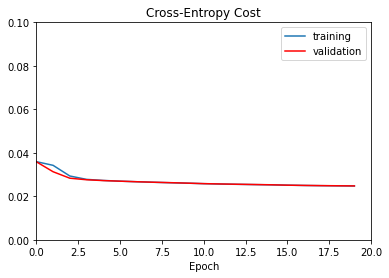

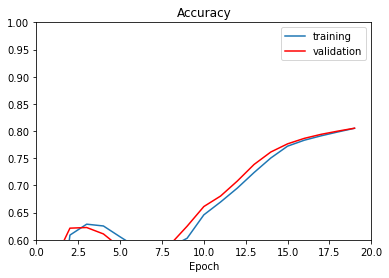

In [18]:
model = MLP([28*28, 300, 100, 10], torch.nn.Sigmoid)
learning_rate = 0.2
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
           Sigmoid-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
           Sigmoid-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
           Sigmoid-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
Epoch 0: 0.034149, 0.286240, 0.029642, 0.575900
Epoch 1: 0.027897, 0.620100, 0.027299, 0.611900
Epoch 2: 0

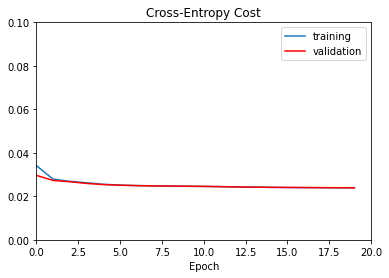

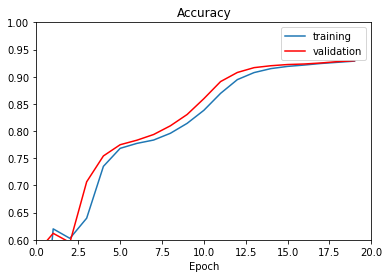

In [19]:
model = MLP([28*28, 300, 100, 10], torch.nn.Sigmoid)
learning_rate = 0.5
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
           Sigmoid-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
           Sigmoid-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
           Sigmoid-7                   [-1, 10]               0
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
Epoch 0: 0.032229, 0.390420, 0.027742, 0.629700
Epoch 1: 0.026908, 0.640820, 0.026436, 0.681400
Epoch 2: 0

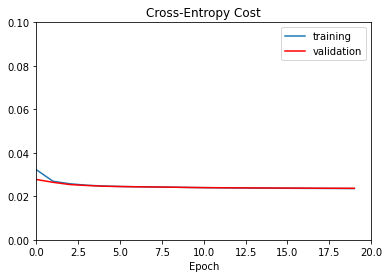

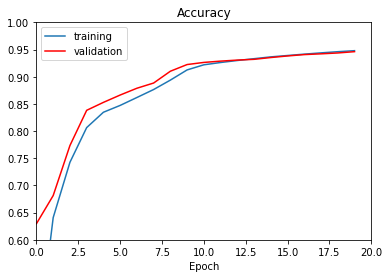

In [22]:
best_sigmoid = MLP([28*28, 300, 100, 10], torch.nn.Sigmoid)
learning_rate = 0.8
nepochs = 20
nbatch = 64

summary(best_sigmoid, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(best_sigmoid, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 5000]       3,925,000
           Sigmoid-3                 [-1, 5000]               0
            Linear-4                  [-1, 300]       1,500,300
           Sigmoid-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
           Sigmoid-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
           Sigmoid-9                   [-1, 10]               0
Total params: 5,456,410
Trainable params: 5,456,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 20.81
Estimated Total Size (MB): 20.91
-------------------------------------

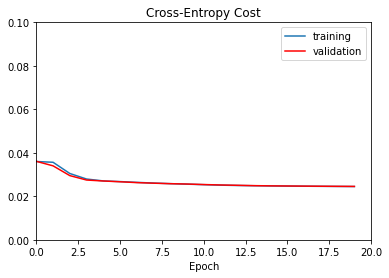

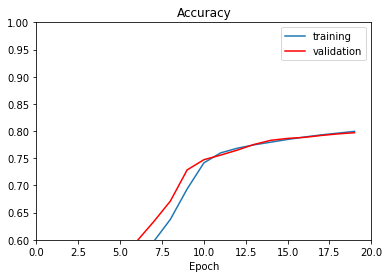

In [21]:
model = MLP([28*28, 5000, 300, 100, 10], torch.nn.Sigmoid)
learning_rate = 0.5
nepochs = 20
nbatch = 64

summary(model, (1,28,28))

cost_hist, cost_hist_valid, acc_hist, acc_hist_valid = train_eval(model, learning_rate, nepochs, nbatch, training_set, validation_set)

plot_results(cost_hist, cost_hist_valid, acc_hist, acc_hist_valid)

In [24]:
def test(model, data):
    test_loader = DataLoader(data, batch_size=64)
    correct = 0
    for inputs, targets in test_loader:
        predictions = model(inputs)
        correct += (torch.argmax(predictions, dim=1) == targets).sum()
    return correct / len(data)

In [26]:
print(f'Accuracy best ReLU: {test(best_relu, test_data)}')
print(f'Accuracy best Sigmoid: {test(best_sigmoid, test_data)}')

Accuracy best ReLU: 0.921999990940094
Accuracy best Sigmoid: 0.9473000168800354


### Summary

Summarize your findings with the different settings in a table

| Units | nepochs | lr | Acc (Train) | Acc (Valid) |
| --- | :-: | :-: | :-: | :-: |
| (784,10,10) | 20 | 0.5 | 94.1% | 93.4% |
| (784,10,10) | 20 | 0.75 | 84.1% | 81.5% |
| (784,10,10) | 20 | 0.9 | 81.7% | 76.4% |
| (784,300,10,10) | 20 | 0.2 | 99.9% | 98.3% |
| (784,300,10,10) | 20 | 0.5 | 99.9% | 98.3% |
| (784,300,10,10) | 20 | 0.8 | 99.4% | 97.7% |
| (784,5000,300,10,10) | 20 | 0.5 | 99.9% | 98.5% |
